<a href="https://colab.research.google.com/github/lsaif/RockTypePropagation/blob/master/Rocktype_Propagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Rocktype Propagation**

####**Github repo setup**

In [0]:
from os.path import join  
from google.colab import drive

ROOT="/content/drive"
drive.mount(ROOT)

MY_GOOGLE_DRIVE_PATH = 'My Drive/gits' 
GIT_USERNAME = "lsaif" 
GIT_TOKEN = "3508092900c8ef7a64b1a8bf0205a601356b340a"  
GIT_REPOSITORY = "RockTypePropagation" 

PROJECT_PATH = join(ROOT, MY_GOOGLE_DRIVE_PATH)

GIT_PATH = "https://" + GIT_TOKEN + "@github.com/" + GIT_USERNAME + "/" + GIT_REPOSITORY + ".git"
%cd "{PROJECT_PATH}" 
!git clone "{GIT_PATH}" 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/gits
fatal: destination path 'RockTypePropagation' already exists and is not an empty directory.


In [0]:
!git branch

* master


####**Installer**

In [0]:
!pip install -q git+https://github.com/tensorflow/docs
!pip install tf-nightly==2.2.0.dev20200218
!pip install --quiet neural-structured-learning

     |████████████████████████████████| 511.7MB 27kB/s 
     |████████████████████████████████| 460kB 38.2MB/s 
     |████████████████████████████████| 2.8MB 56.1MB/s 
     |████████████████████████████████| 2.9MB 35.4MB/s 
     |████████████████████████████████| 778kB 40.1MB/s 
ERROR: tensorflow 1.15.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
  Found existing installation: gast 0.2.2
    Uninstalling gast-0.2.2:
      Successfully uninstalled gast-0.2.2
  Found existing installation: h5py 2.8.0
    Uninstalling h5py-2.8.0:
      Successfully uninstalled h5py-2.8.0
     |████████████████████████████████| 112kB 5.0MB/s 


####**Authenticate to access Google Drive**

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

####**Import supporting libraries**

In [0]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from os import listdir
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn import linear_model
from keras.optimizers import SGD, adam
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import timeit

np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

import neural_structured_learning as nsl
tf.keras.backend.clear_session()

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Using TensorFlow backend.


Version:  2.2.0-dev20200218
Eager mode:  True
Found GPU at: /device:GPU:0


####**Data Loading**

In [0]:
def LoadData(url,filename):
  fluff, id = url.split('=')
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile(filename)
  return filename

LoadData(url="https://drive.google.com/open?id=1JAc9PfGK0b4IrtRkv7m5o2yhD8P_bb9t", filename="hfu_data.csv")
dset = pd.read_csv("hfu_data.csv", sep=';').set_index('Well')
print(dset.head(5))
dset = dset.dropna()
#sns.pairplot(dset[["GR", "NPHI", "RHOB", "ILD", "PHIE", "SWE", "HFU"]], diag_kind="kde")

             Depth     Por   Perm  Fasies_enc  Fasies  HFU        GR  \
Well                                                                   
JTB-047  2425.2936  0.0436  0.020           2  LITHIC    9  159.8818   
JTB-047  2425.5984  0.0557  0.080           2  LITHIC   10  145.3258   
JTB-048  2001.5456  0.1649  0.140           2  LITHIC    7  193.9869   
JTB-048  2001.6980  0.1649  0.140           2  LITHIC    7  193.9899   
JTB-051  2196.6374  0.0486  2.883           3    LAVA   14   85.0744   

             NPHI      RHOB     ILD     PROX      PHIE       SWE  
Well                                                              
JTB-047  0.169437  2452.768  6.8167  19.4682  0.134611  0.966523  
JTB-047  0.173898  2423.823  6.7381  21.6627  0.145651  0.899416  
JTB-048  0.265260  2367.800  4.0185  12.8280  0.195563  0.837456  
JTB-048  0.256040  2371.300  4.0252   7.2460  0.199310  0.823007  
JTB-051  0.156100  2483.100  4.4219   3.4980  0.115553  1.000000  


In [0]:
dset.describe()

,Depth,Por,Perm,Fasies_enc,HFU,GR,NPHI,RHOB,ILD,PROX,PHIE,SWE
count,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000
mean,2108.175832,0.094492,0.181952,2.951613,9.403226,116.829169,0.155191,2432.553081,23.999779,29.949508,0.117938,0.943510
std,70.253616,0.077514,0.401895,1.165451,3.037793,62.166360,0.067177,119.694973,21.577453,27.581440,0.082739,0.077179
min,2001.545600,0.010000,0.020000,1.000000,5.000000,18.269600,0.058100,2099.600000,1.206400,2.599000,0.026135,0.786726
25%,2069.275000,0.025500,0.042500,2.000000,7.000000,62.756425,0.091350,2337.275000,3.134175,4.695250,0.046341,0.867789
50%,2073.850000,0.077500,0.100000,3.000000,8.000000,119.454000,0.139050,2479.050000,15.183000,22.555950,0.087339,0.999982
75%,2124.125000,0.147000,0.110000,4.000000,12.000000,178.334575,0.233050,2516.200000,42.627000,45.264050,0.198821,0.999996
max,2425.598400,0.277000,2.883000,5.000000,16.000000,196.258700,0.272400,2621.200000,71.072400,90.462200,0.306075,1.000000


####**Pre-processing**

In [0]:
db = dset[['GR','ILD','PROX','HFU']].copy()
X = db.iloc[:,0:3].values
Y = db.pop['HFU']
Y = label_binarize(Y, classes=[0,1,2,3,4,5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
test = 0.20
seed = 0
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=test, random_state=seed)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print (Y_test)

[[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]]


####**Model**

In [0]:
def ModelAnn():
  classifier = Sequential([
                           Dense(256, activation = 'relu', input_dim=3),
                           #Dense(128,activation = 'relu'), 
                           Dense(17, activation='softmax')                     
        ])
  lr = 0.1
  decay = 0.0001
  momentum = 0.75
  sgd= SGD(lr=lr, momentum=momentum, decay=decay,nesterov=False)
  adm = adam(lr=lr,decay=decay)
  classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','mae','msle'])
  return classifier

def ModelLinear():
  classifier = linear_model.SGDClassifier(loss='huber', penalty='elasticnet', verbose=1)
  return classifier
  
def ModelRF():
        classifier = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1, verbose=1)
        return classifier

####**Train, test, predict**

In [0]:
#classifier = KerasClassifier(build_fn=ModelAnn, epochs=300, batch_size=5, verbose=1)
classifier = ModelAnn()
#with tf.device('/cpu:0'):
def fitmodel():
  with tf.device('/device:GPU:0'):
    history = classifier.fit(X_train, Y_train, validation_split=0.2, epochs=1000, batch_size=5, verbose=1)
    Y_predict = classifier.predict(X_test)
    return history, Y_predict

history, Y_predict = fitmodel()

print('GPU (s):')
#cpu_time = timeit.timeit('fitmodel()', number=1, setup="from __main__ import fitmodel")
#print(cpu_time)

Train on 39 samples, validate on 10 samples
Epoch 1/1000
39/39 [==============================] - 2s 47ms/sample - loss: 2.8164 - accuracy: 0.0513 - mae: 0.1106 - msle: 0.0268 - val_loss: 2.8003 - val_accuracy: 0.0000e+00 - val_mae: 0.1105 - val_msle: 0.0268
Epoch 2/1000
39/39 [==============================] - 0s 1ms/sample - loss: 2.6925 - accuracy: 0.2564 - mae: 0.1096 - msle: 0.0262 - val_loss: 2.6962 - val_accuracy: 0.0000e+00 - val_mae: 0.1097 - val_msle: 0.0264
Epoch 3/1000
39/39 [==============================] - 0s 1ms/sample - loss: 2.5824 - accuracy: 0.3333 - mae: 0.1086 - msle: 0.0257 - val_loss: 2.6138 - val_accuracy: 0.0000e+00 - val_mae: 0.1090 - val_msle: 0.0261
Epoch 4/1000
39/39 [==============================] - 0s 1ms/sample - loss: 2.4811 - accuracy: 0.3333 - mae: 0.1076 - msle: 0.0251 - val_loss: 2.5449 - val_accuracy: 0.0000e+00 - val_mae: 0.1082 - val_msle: 0.0258
Epoch 5/1000
39/39 [==============================] - 0s 1ms/sample - loss: 2.3887 - accuracy: 0.33

In [0]:
print(Y_predict.argmax(1))
print(Y_test.argmax(1))

[ 7  5  7  7  6  7 10 13  7 10  7  8  8]
[ 5  6  7  8  8  6  7 12  7  8  5 14  8]


####**Check**

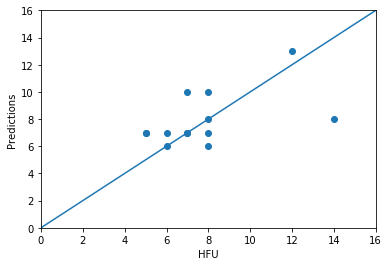

In [0]:
plt.scatter(Y_test.argmax(1), Y_predict.argmax(1))
plt.xlabel('HFU')
plt.ylabel('Predictions')
lims = [0, 16]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

from sklearn.metrics import confusion_matrix, accuracy_score
#cm = confusion_matrix(Y_test, Y_predict)
acc = accuracy_score(Y_test.argmax(1), Y_predict.argmax(1))
#print(cm)
#print(acc)

####**History**

Text(0, 0.5, 'Accuracy')

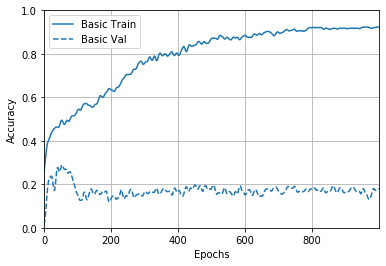

In [0]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail(5)
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = 'accuracy')
plt.ylim([0, 1])
plt.ylabel('Accuracy')

####**Propagation**

In [0]:
LoadData(url="https://drive.google.com/open?id=101yfKa9jPW3umaUpi9SXzgvQqzQA4Zf5", filename="wire_jtb_hfu.csv")
wire = pd.read_csv("wire_jtb_hfu.csv", sep=';').set_index('WELL')
LoadData(url="https://drive.google.com/open?id=1WHGb8A7J53eDeJtrGY59VNoR5i3JgoKL", filename="efac.csv")
efac = pd.read_csv("efac.csv", sep=';').set_index('WELL')

data = wire.merge(efac, how='right', left_on=['WELL','DEPTH'], right_on=['WELL','DEPTH'])
data = data.dropna()
print(data.head(5))

AttributeError: ignored

In [0]:
X_data = data.iloc[:,[1,2,4,6]]
Y_data = classifier.predict(X_data).argmax(1)
print(X_data.head(5))
prediction = data
prediction['HFU_PRED'] = Y_data
prediction.to_csv('HFU_pred.csv', sep=',')
from google.colab import drive
drive.mount('drive')
!cp HFU_pred.csv "drive/My Drive/Colab Notebooks"

              GR     ILD    PROX  EFAC_7
WELL                                    
JTB-050  59.1110  2.7790  2.0920       2
JTB-050  58.6135  2.5688  2.0535       2
JTB-050  59.6001  2.2911  1.9829       2
JTB-050  61.6514  2.0144  1.3451       2
JTB-050  63.1988  1.8095  1.4411       2
Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


####**Commit to Github**

In [0]:
%cd "{PROJECT_PATH}"
%cd "{GIT_REPOSITORY}" 
!git add .
!git commit -m "add from Google Colab"
!git config --global user.email "luthfi@geodin.net"
!git config --global user.name "lsaif"
!git push -u origin master

/content/drive/My Drive/gits
/content/drive/My Drive/gits/RockTypePropagation
On branch master
Your branch is up to date with 'origin/master'.

nothing to commit, working tree clean
Branch 'master' set up to track remote branch 'master' from 'origin'.
Everything up-to-date
